In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModel import TrainSingleModel
from Classes.DataProcessing.RamLoader import RamLoader
from Classes.DataProcessing.ts_RamGenerator import modified_data_generator
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)



model_type = "DENSE_baseline"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "standard"
use_noise_augmentor = False
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()



1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
2 3
Balancing due to disguised labels.
This functions barely works, and is a piece of shit that should not be trusted. Only works because noise has id: 0
{'noise': 84799, 'earthquake': 84799, 'explosion': 82246}
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded noise non-noise dataset.
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (10631, 0.2526)  |  explosion: (10106, 0.2402)  |  noise: (21343, 0.5072)  
Val ds:
earthquake: (242, 0.0371)  |  explosion: (3125, 0

In [2]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = False
start_from_scratch = False
use_reduced_lr = False
log_data = False

beta = 3

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModel(x_train, y_train, x_val, y_val, x_test, y_test, noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, results_df = None, results_file_name = None, index = None, 
                              start_from_scratch = start_from_scratch, beta = beta)
params = {
        "batch_size" : 128,
        "epochs" : 50,
        "learning_rate" : 0.01,
        "optimizer" : "sgd",
        "units" : 50,
        "dense_activation" : "relu",
        "output_layer_activation" : "sigmoid"
    }

model, _ = modelTrain.run(16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, **params)

['20210421-193355']
[   {'model_type': 'DENSE_baseline'},
    {   'batch_size': 128,
        'dense_activation': 'relu',
        'epochs': 50,
        'learning_rate': 0.01,
        'optimizer': 'sgd',
        'output_layer_activation': 'sigmoid',
        'units': 50}]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 3)]         0         
_________________________________________________________________
flatten (Flatten)            (None, 18000)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                900050    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 900,101
Trainable params: 900,101
Non-trainable params: 0
_________________________________________________

- val_f3: 0.0134
Epoch 26/50
328/328 [==============================] - 2s 5ms/step - loss: 0.6920 - binary_accuracy: 0.5179 - precision: 0.9122 - recall: 0.0228 - val_loss: 0.6937 - val_binary_accuracy: 0.4897 - val_precision: 0.8148 - val_recall: 0.0133
- val_f3: 0.0148
Epoch 27/50
328/328 [==============================] - 1s 5ms/step - loss: 0.6920 - binary_accuracy: 0.5192 - precision: 0.9181 - recall: 0.0239 - val_loss: 0.6937 - val_binary_accuracy: 0.4897 - val_precision: 0.8148 - val_recall: 0.0133
- val_f3: 0.0148
Epoch 28/50
328/328 [==============================] - 2s 5ms/step - loss: 0.6920 - binary_accuracy: 0.5190 - precision: 0.9159 - recall: 0.0235 - val_loss: 0.6937 - val_binary_accuracy: 0.4897 - val_precision: 0.8148 - val_recall: 0.0133
- val_f3: 0.0148
Epoch 29/50
328/328 [==============================] - 1s 5ms/step - loss: 0.6920 - binary_accuracy: 0.5189 - precision: 0.9210 - recall: 0.0239 - val_loss: 0.6937 - val_binary_accuracy: 0.4897 - val_precision: 0.81

3092 8 3263 37


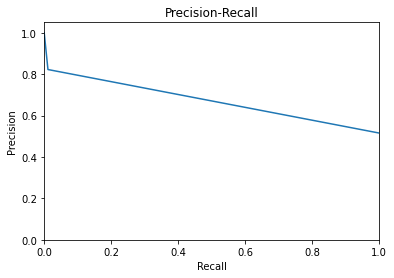

['noise', 'not_noise']
3N


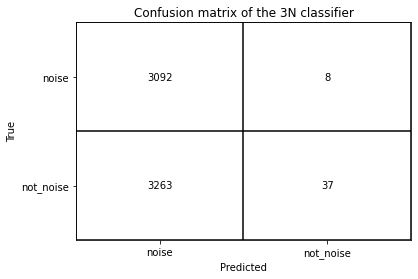

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3092,    8],
       [3263,   37]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.49      1.00      0.65      3100
   not_noise       0.82      0.01      0.02      3300

    accuracy                           0.49      6400
   macro avg       0.65      0.50      0.34      6400
weighted avg       0.66      0.49      0.33      6400



In [3]:
conf, report, accuracy, precision, recall, fscore = helper.evaluate_generator(model, x_val, y_val, params["batch_size"],
                                                                             loadData.label_dict, num_channels, noiseAug,
                                                                             scaler_name, plot_conf_matrix = True, plot_p_r_curve = True, beta = beta)

In [4]:
precision, recall, fscore

(0.82222200000000001, 0.011212, 0.012439)

In [5]:
import matplotlib as plt
plt.plotconfusion(y_val, 2)

AttributeError: module 'matplotlib' has no attribute 'plotconfusion'